In [1]:
from collections import namedtuple, deque
from itertools import count
import numpy as np
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image

In [3]:
env = gym.make('CartPole-v0').unwrapped

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [5]:
plt.ion()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

In [8]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [10]:
resize = T.Compose([T.ToPILImage(),
                   T.Resize(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0 )

/usr/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [11]:
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    
    screen = screen[:, int(screen_height*0.4): int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)

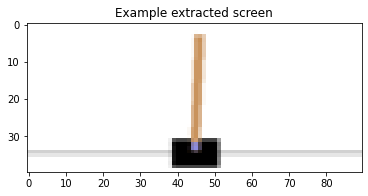

In [12]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [13]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0



In [14]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device = device, dtype=torch.long)

In [ ]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    

In [30]:
import gym

In [36]:
env = gym.make('CartPole-v0')

In [37]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [38]:
env.reset()

array([-0.03576558, -0.02198377,  0.0137685 ,  0.03772242], dtype=float32)

In [54]:
import gym
env = gym.make("CartPole-v1")
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()
env.close()

In [12]:
env.close()

In [27]:
env.action_space.n

2

In [43]:
print(env.action_space)

Discrete(2)


In [47]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [48]:
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [52]:
from gym import spaces
space = spaces.Discrete(8)
x = space.sample()
print(x)

6
